# Methodo :

- Dès l'import, on génère toute les calendar_class possible. Elles sont dans un dictionnaire T_labels.
- On génère aussi un dictionnaire 'D' où à chaque calendar-class est associé un dic_class2rpz/ dic_rpz2class
- Pour l'entrainement, on choisi T_labels[args.calendar_class]
- Pour la calibration, on choisi args.calibration_calendar_class. On a le choix de switcher à travers la calendar-class que l'on veut.

## Import

In [1]:
import sys
import os

# Obtenir le chemin du dossier parent
current_path = notebook_dir = os.getcwd()
# current_path = os.path.dirname()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))

# Ajouter le dossier parent au chemin de recherche des modules
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


# Personnal Import
from residual_classification import load_and_train_model,get_classifier_inputs,sklearn_grid_search,train_classifier,load_inputs_preds_and_init_PI,load_df_dummies,load_df_classification,load_dataset_for_classifier_for_ONE_single_station,labelise_residual,Continuous_res2Discret_label,update_results_by_station,get_scores,load_init_calibration_set_and_dummies_variables
from utils.utilities import get_time_delta_holidays,get_school_holidays,CPU_Unpickler
from utils.utilities_DL import get_MultiModel_loss_args_emb_opts,load_init_trainer
from trainer import MultiModelTrainer
from plotting.plotting_bokeh import generate_bokeh

from constants.config import convert_into_parameters
from constants.paths import FOLDER_PATH,FILE_NAME,save_folder
import torch

from PI.QuanTraffic_method import get_QuanTraffic_calibration_table

'pynvml' is not available on this environment.


## Choose the saved model : 
Here the 'best one', which mean the one on quantile loss with the smallest valid_loss. 

`Valid loss are not comparable for differents: `
-  K_fold
- fold
- single_station 
- dataset 
- validation


In [2]:
# ===== Load Saved Best Model : Load Dataset, Trainer, dataloader ...
save_model_folder = f"{save_folder}best_models/"
model_perf_path = f"{save_model_folder}model_args.pkl"
model_perf = CPU_Unpickler(open(model_perf_path,'rb')).load()
#model_perf = pickle.load(open(model_perf_path,'rb'))

best_valid_loss = np.inf 
for trial in model_perf['model'].keys():

    valid_loss = model_perf['model'][trial]['performance']['valid_loss']
    loss_function  = model_perf['model'][trial]['args']['loss_function_type']
    if loss_function == 'quantile':
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_trial = trial

best_model = f"{save_model_folder}{best_trial}_best_model.pkl"
print(best_model)

save/best_models/67512_STGCN_F6f2_256_500_011_03_06_2024_best_model.pkl


# But, here a pretty good model for trained Fold1 is available: 

In [3]:
best_trial = '33224_STGCN_F6f0_256_500_011_03_06_2024'  #F6f0 mean it's the first fold trained, which correspond to the number1, cause the true 'f0' has been used for HP tuning ...
best_model = f'save/best_models/{best_trial}_best_model.pkl'

In [4]:
# ==== Update Some Parameters:
config = model_perf['model'][best_trial]['args']
config['abs_path'] = f"{os.path.abspath(os.getcwd())}/"
config['device'] = 'cuda:0' if torch.cuda.is_available() else 'cpu'
config['K_fold'] = 6
args = convert_into_parameters(config)
# ==== ....

# ==== Load un-trained model: 
Datasets,DataLoader_list,dic_class2rpz,nb_words_embedding,time_slots_labels,dic_rpz2class = load_init_trainer(FOLDER_PATH,FILE_NAME,args)
(loss_function,Model_list,Optimizer_list,Scheduler_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding,dic_class2rpz,n_vertex = len(Datasets[0].spatial_unit))
multimodeltrainer = MultiModelTrainer(Datasets,Model_list,DataLoader_list,args,Optimizer_list,loss_function,Scheduler_list,args_embedding=args_embedding,dic_class2rpz=dic_class2rpz,show_figure=False)
# ==== ....

# ==== Load Trained Weight:
saved_checkpoint =  torch.load(best_model) if torch.cuda.is_available() else torch.load(best_model,map_location='cpu')
trainer = multimodeltrainer.Trainers[1]   # Fold1, très important car Fold0 a été pris pour le HP-Tuning. 
trainer.model.load_state_dict(saved_checkpoint['state_dict'])
# ===== ....

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0


/Users/romainrochas/opt/anaconda3/envs/ray2/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00264133]
not reaching the requested tolerance 5.960464477539062e-07.
Use iteration 16 instead with accuracy 
0.002533855713524944.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/Users/romainrochas/opt/anaconda3/envs/ray2/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00253386]
not reaching the requested tolerance 5.960464477539062e-07.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/Users/romainrochas/opt/anaconda3/envs/ray2/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00346122]
not reaching the requested tolerance 5.960464477539062e-07.
Use iteration 21 instead with accuracy 
0.0034612195312773474.

  _, eigvec = lobpcg(XH_X, X, to

<All keys matched successfully>

# Calibration CQR classique :

In [ ]:
Q = trainer.conformal_calibration(trainer.alpha,trainer.dataset,conformity_scores_type = 'max_residual',quantile_method = 'classic',print_info = True)
pi,pi_cqr = generate_bokeh(trainer,trainer.dataloader,trainer.dataset,Q,args,dic_class2rpz,station=0,show_figure = True,save_plot = False)

Loading BokehJS ...

### Calibration CQR autres : 

In [ ]:
for calibration_calendar_class in [1,2,3]:
    Q = trainer.conformal_calibration(trainer.alpha,trainer.dataset,conformity_scores_type = 'max_residual',quantile_method = 'compute_quantile_by_class',print_info = True,calibration_calendar_class = calibration_calendar_class)
    pi,pi_cqr = generate_bokeh(trainer,trainer.dataloader,trainer.dataset,Q,args,dic_class2rpz,station=0,show_figure = True,save_plot = False,calibration_calendar_class = calibration_calendar_class)


Proportion of label with quantile order set to 1: 6.0%


Loading BokehJS ...


Proportion of label with quantile order set to 1: 100.0%


Loading BokehJS ...


Proportion of label with quantile order set to 1: 7.7%


Loading BokehJS ...

### QuanTraffic

In [8]:
# ==== QuanTraffic Calibration : 
# Load Y_pred_calibration1 and Y_pred_calibration2
split_prop = 0.5
nb_quantiles = 99
n_lambda = 50 #41 
lambda_list = np.arange(0,n_lambda)/n_lambda

Q_calibration_table = get_QuanTraffic_calibration_table(trainer,split_prop,nb_quantiles,lambda_list)
pi,pi_cqr = generate_bokeh(trainer,trainer.dataloader,trainer.dataset,Q_calibration_table.unsqueeze(0),args,dic_class2rpz,station=0,show_figure = True,save_plot = False)

Loading BokehJS ...

## `Aucune des calibrations proposées n'a d'intérêt. elles sont tous mauvaise. Elles renvoient tous un résultas plus mauvais.`

# Etude des Residual par CalendarClass:

### Init : 

In [5]:
# ==== Init ...
dataloader_set = 'cal'
split_prop = 0.7
task = 'classification' # 'regression'

if task == 'classification':
    fraction_maxi = 2
    fraction_std_step = 4
if task == 'regression':
    standardization = 'minmax' # 'standardize'

# ==== ...


# Load Holidays (if needed for classification): 
bank_holidays = get_time_delta_holidays(agg_minutes = True,agg_hour = False)
school_holidays = get_school_holidays(city='Lyon',freq = f'{60/trainer.dataset.time_step_per_hour}min')

Only French Holidays from 2019 to 2020 has been implemented


## MLP Classifier
La classification se fait sur une unique station (La première 'Ampère').

In [6]:
results_classifier = pd.DataFrame(columns = ['Station','Score Lower', 'Score Upper'])
(df_dummies,X_cal,Y_cal,T_cal,T_cal_exact_dates,res_lower,res_upper) = load_init_calibration_set_and_dummies_variables(trainer,bank_holidays,school_holidays,calibration_calendar_class = 3,dataloader_set= 'cal',
                                                                                                                       add_bank_holidays = True,
                                                                                                                       add_scholar_holidays = True,
                                                                                                                       hour = True,
                                                                                                                       weekday = True,
                                                                                                                       minutes = True)
for num_station,station_name in enumerate(trainer.dataset.spatial_unit):
    ### Load Data:
    (datasets,datasets_valid,df_classification,Y_train_lower,Y_train_upper) = load_dataset_for_classifier_for_ONE_single_station(df_dummies,res_lower,res_upper,split_prop,station = num_station)
    ### Load and train Model : 
    Models,parameter= load_and_train_model(datasets,datasets_valid,df_classification,task,fraction_maxi=fraction_maxi,fraction_std_step=fraction_maxi,plot = False)

    ### Return Score on Validation DataSet : 
    score_lower,score_upper = get_scores(Models)
    results_classifier = update_results_by_station(results_classifier,station_name,score_lower,score_upper,num_station)

In [7]:
results_classifier

Station  Score Lower  Score Upper
0              Ampère Victor Hugo     0.542169     0.562823
1                       Bellecour     0.506885     0.487091
2                       Brotteaux     0.510327     0.421687
3                      Charpennes     0.518933     0.446644
4                      Cordeliers     0.498279     0.464716
5                    Croix Paquet     0.474182     0.530981
6                    Croix-Rousse     0.493976     0.531842
7                           Cuire     0.534423     0.481928
8                          Cusset     0.509466     0.556799
9                         Debourg     0.515491     0.435456
10                        Flachet     0.512048     0.518072
11                           Foch     0.536145     0.550775
12                 Gare d'Oullins     0.446644     0.441480
13                  Gare de Vaise     0.456971     0.433735
14             Gare de Vénissieux     0.515491     0.447504
15                      Garibaldi     0.514630     0.467298
16                  Gorge de Loup     0.546472     0.475043
17                 Grange Blanche     0.472461     0.578313
18                    Gratte Ciel     0.530120     0.533563
19                    Guillotière     0.568847     0.562823
20                          Hénon     0.464716     0.474182
21  Hôtel de ville - Louis Pradel     0.495697     0.421687
22                      Jean Macé     0.496558     0.478485
23                        La soie     0.425129     0.438898
24               Laurent Bonnevay     0.507745     0.548193
25                        Laënnec     0.438898     0.489673
26                        Masséna     0.524096     0.551635
27                 Mermoz - Pinel     0.512048     0.467298
28             Monplaisir Lumière     0.523236     0.473322
29                        Parilly     0.532702     0.524096
30                      Part-Dieu     0.580034     0.556799
31                       Perrache     0.512909     0.525818
32                 Place Guichard     0.512909     0.432874
33              Place Jean Jaurès     0.532702     0.442341
34        République Villeurbanne     0.495697     0.453528
35                     Sans Souci     0.491394     0.514630
36                Saxe - Gambetta     0.578313     0.598967
37               Stade de Gerland     0.430293     0.429432
38                          Valmy     0.509466     0.520654
39                     Vieux Lyon     0.493115     0.474182

Load and Train Model : 

In [7]:
from residual_classification import  get_train_valid_lower_upper
(X_train,X_valid,Y_train_lower,Y_valid_lower,Y_train_upper,Y_valid_upper) = get_train_valid_lower_upper(df_classification,split_prop)

In [ ]:
load_and_train_model(df_classification,split_prop = 0.7, task = 'regression')

# Sklearn Classifier

In [6]:

from sklearn.datasets import make_circles, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier



names = [
    "Nearest Neighbors",
    "SVC-Linear",
    #"SVC-rbf",
    #"SVC-poly",
    #"RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    #"Neural Net",
    "AdaBoost",
    "Naive Bayes",
    #"QDA",
]



classifiers = [
    KNeighborsClassifier(n_neighbors=20, weights='distance'),
    SVC(kernel = 'linear',gamma=0.5, random_state=42),
    #SVC(kernel = 'rbf',gamma=0.5, random_state=42),
    #SVC(kernel = 'poly',gamma=0.5, random_state=42),
    #SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(criterion='log_loss', max_depth=10, min_samples_split=10,
                       random_state=42, splitter='random'),
    RandomForestClassifier(max_depth=15, max_features=None, min_samples_split=10,
                        n_estimators=50, random_state=42),
    #MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm='SAMME', learning_rate=0.1, n_estimators=10,
                   random_state=42),
    GaussianNB(),
    #QuadraticDiscriminantAnalysis(var_smoothing=0.01),
]

SearchSpaces = [dict(n_neighbors = [1,2,3,5,10,20], weights = ['uniform','distance']),  #KneighborsClassifier
                dict(C = [0.01,0.025,0.5,0.75,1.0,1.5,2],kernel = ['linear','rbf','poly','sigmoid'], degree = [1,2,3,4], gamma = ['scale','auto',0.1,0.5,1,2,3]),  # SVC
                dict(), #GaussianProcessClassifier
                dict(criterion = ['gini','entropy','log_loss'],splitter = ['best','random'],max_depth = [1,2,3,5,8,10,15,20],min_samples_split = [2,3,4,5,10]), #DecisionTreeClassifier
                dict(n_estimators = [10,20,50,100,250,500],criterion = ['gini','entropy','log_loss'],max_depth = [1,2,3,5,8,10,15,20],min_samples_split = [2,3,4,5,10],max_features = ['sqrt', 'log2', None]),#RandomForestClassifier
                #dict(), #MLPClassifier  # Déjà implémenté en Torch
                dict(n_estimators = [10,20,50,100,250,500],learning_rate=[1e-4,1e-3,1e-2,1e-1,1,10],algorithm =['SAMME','SAMME.R']), #AdaBoostClassifier
                dict(var_smoothing = [1e-9,1e-5,1e-3,1e-2]), #GaussianNB
                #dict(), #QuadraticDiscriminantAnalysis
                ]

# ICI hyppothèse forte que la distribution des residuals est la même sur le train et sur le Valid. Ce qui n'est pas le cas en réalité
- L'hyppothèse est utilisé lors des lignes 'Continuous_res2Discret_label' qui labelise le residual en fonction de son volume. On devrait peut être MinMax Norma d'abord ou plutôt standardiser (car résidual - sauf outliers- suivent une gaussienne ?)

In [7]:
names = [
    "Nearest Neighbors",
    "SVC-Linear",
    "SVC-Poly",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]


classifiers = [
    KNeighborsClassifier(n_neighbors=10, weights='distance'),
    SVC(kernel = 'linear',gamma=0.5, random_state=42),
    SVC(kernel = 'poly',gamma=0.5, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(criterion='log_loss', max_depth=10, min_samples_split=10,
                       random_state=42, splitter='random'),
    RandomForestClassifier(max_depth=15, max_features=None, min_samples_split=10,
                        n_estimators=50, random_state=42),
    AdaBoostClassifier(algorithm='SAMME', learning_rate=0.1, n_estimators=10,
                   random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis() #var_smoothing=0.01
]

In [10]:
# Init:
gridsearch =  False

# Use only Simple Classifier (SVC-linear and Random Forest):
names = ["SVC-Linear","Random Forest",]
classifiers = [SVC(kernel = 'linear',gamma=0.5, random_state=42),
               RandomForestClassifier(max_depth=15, max_features=None, min_samples_split=10,
                        n_estimators=50, random_state=42)
                        ]


# iterate Feature Tables (With or Without bank-holidays/scholar-holidays):

for add_holidays in [True,False]:
    for weekday in [True,False]:
        for hour in [True,False]:
            for minutes in [True,False]:
                if not((minutes | hour) | (weekday|add_holidays)):
                    print('\nNo Features')
                else: 
                    weekday_hour_minutes = f"{'weekday, ' if weekday else '' }{'hour, ' if hour else '' }{'minutes.' if minutes else '' }"
                    print(f'\nHolidays Added: {add_holidays} and {weekday_hour_minutes} ')
                    (df_dummies,X_cal,Y_cal,T_cal,T_cal_exact_dates,res_lower,res_upper) = load_init_calibration_set_and_dummies_variables(trainer,bank_holidays,school_holidays,calibration_calendar_class,dataloader_set,
                                                                                                                                        add_bank_holidays = True,
                                                                                                                                        add_scholar_holidays = True,
                                                                                                                                        hour = True,
                                                                                                                                        weekday = True,
                                                                                                                                        minutes = True)
                    (datasets,datasets_valid,df_classification,Y_train_lower,Y_train_upper) = load_dataset_for_classifier_for_ONE_single_station(df_dummies,res_lower,res_upper,split_prop,station = num_station)
                    labels,step = labelise_residual(Y_train_lower,fraction_maxi = 2,fraction_std_step = 4)

                    # iterate over Residuals (Lower-band residuals, Upper-band residuals):
                    for ds_cnt, (ds,ds_valid,name_ds) in enumerate(zip(datasets,datasets_valid,['Lower Residual', 'Upper Residual'])):
                        print(name_ds)
                        (X_train,X_test,y_train,y_test) =  get_classifier_inputs(ds,ds_valid,labels,step)

                        # iterate over classifiers
                        for name, clf,param_grid in zip(names, classifiers,SearchSpaces):
                            print('Classifier: ',name)
                            if gridsearch: 
                                sh = sklearn_grid_search(clf,X_train, y_train,param_grid,cv=5,factor=2)
                            else: 
                                clf = train_classifier(clf,X_train,y_train,X_test,y_test)

Only French Holidays from 2019 to 2020 has been implemented

Holidays Added: True and weekday, hour, minutes. 
Lower Residual
Classifier:  SVC-Linear
Score on Test Dataset: 0.45438898450946646
Classifier:  Random Forest
Score on Test Dataset: 0.4449225473321859
Upper Residual
Classifier:  SVC-Linear
Score on Test Dataset: 0.4664371772805508
Classifier:  Random Forest
Score on Test Dataset: 0.4819277108433735

Holidays Added: True and weekday, hour,  
Lower Residual
Classifier:  SVC-Linear
Score on Test Dataset: 0.4569707401032702
Classifier:  Random Forest
Score on Test Dataset: 0.4509466437177281
Upper Residual
Classifier:  SVC-Linear
Score on Test Dataset: 0.4664371772805508
Classifier:  Random Forest
Score on Test Dataset: 0.4793459552495697

Holidays Added: True and weekday, minutes. 
Lower Residual
Classifier:  SVC-Linear
Score on Test Dataset: 0.2857142857142857
Classifier:  Random Forest
Score on Test Dataset: 0.2857142857142857
Upper Residual
Classifier:  SVC-Linear
Score on Te

### Comparaison avec model Naif : 

In [ ]:
label_y1 = Continuous_res2Discret_label(df_classification.res_lower,labels)
label_y2 = Continuous_res2Discret_label(df_classification.res_upper,labels)
a = [np.random.randint(8) for _ in range(len(label_y1))]
b = [label_y2.value_counts().idxmax() for _ in range(len(label_y2))]
print('Naive Classifier for res_lower:\nrandom:',(label_y1 == a).mean(), '\nnaive 1:',(label_y1 == b).mean()) 
print('Naive Classifier for res_upper:\nrandom:',(label_y2 == a).mean(), '\nnaive 1:',(label_y2 == b).mean()) 


/Users/romainrochas/opt/anaconda3/envs/ray/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/romainrochas/opt/anaconda3/envs/ray/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/romainrochas/opt/anaconda3/envs/ray/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrec

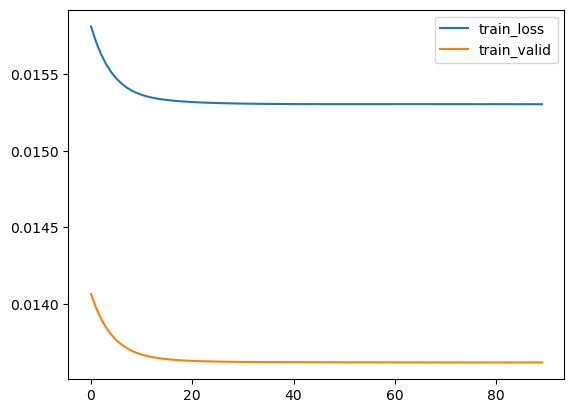

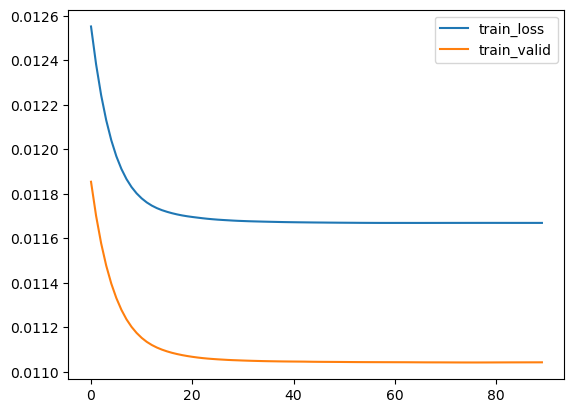

In [9]:
#(X_cal,Y_cal,T_cal,T_cal_exact_dates,res_lower,res_upper) = load_inputs_preds_and_init_PI(trainer,calibration_calendar_class=3,dataloader_set = 'cal')
#df_dummies = load_df_dummies(T_cal_exact_dates,bank_holidays,school_holidays, add_bank_holidays = True, add_scholar_holidays = True)
#df_classification = load_df_classification(df_dummies,res_lower,res_upper,station = 0)
dataloader_set = 'cal' ?????,
(datasets,datasets_valid,df_classification,Y_train_lower,Y_train_upper) = load_dataset_for_classifier_for_ONE_single_station(trainer,split_prop,bank_holidays,school_holidays,station = 0,dataloader_set = dataloader_set,
                                                                                                               add_bank_holidays = True,add_scholar_holidays = True,
                                                                                                               hour = True,weekday = True,minutes = True)  

(Models,mini_l,maxi_l,mini_u,maxi_u) = load_and_train_model(df_classification,split_prop = 0.7)

### Maintenant les modèles sont correctement entrainés.
### Selon les caractéristique contextuelles (calendar information), il est capable de deviner le Lower-residual / Upper-Residual. A prioi il ne le fait pas très bien, sinon c'est que le premier model est mal entrainé ? Car biais pas corrigé dessus...

Band:  lower
Band:  upper


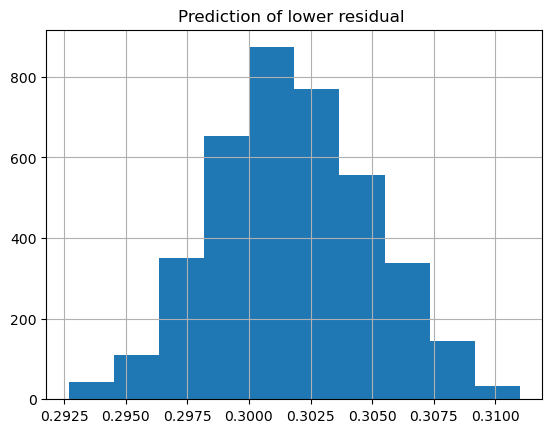

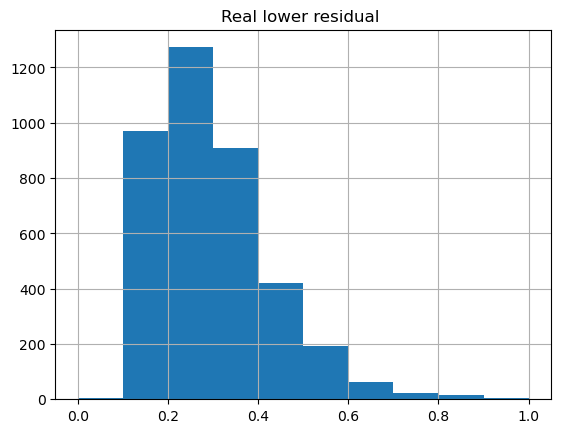

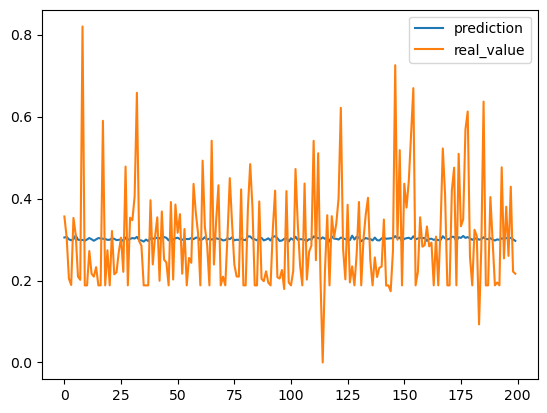

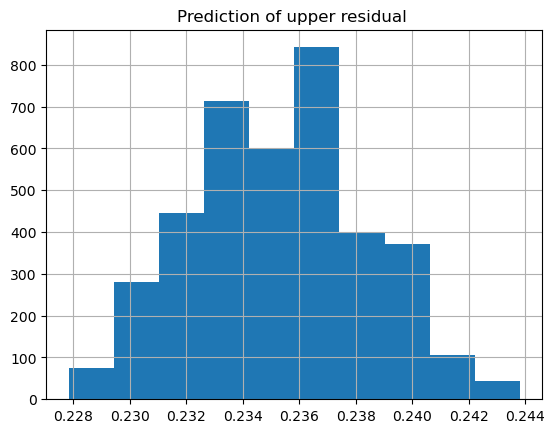

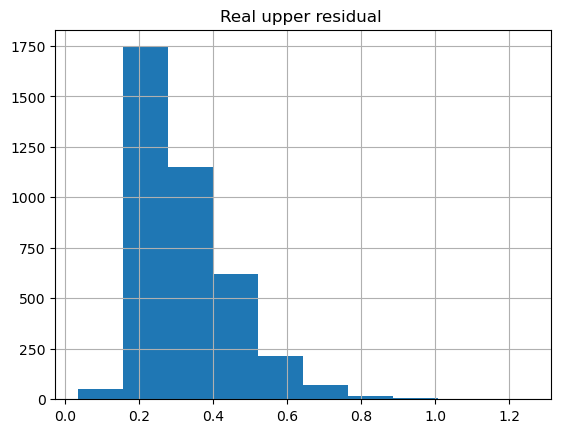

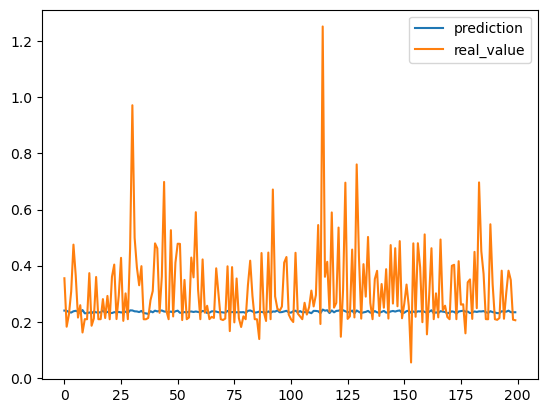

In [24]:
# Load Data
(X_test,Y_test,T_test,T_test_exact_dates,test_res_lower,test_res_upper) = load_inputs_preds_and_init_PI(trainer,calibration_calendar_class=3,dataloader_set = 'test')
test_df_dummies = load_df_dummies(T_test_exact_dates,bank_holidays,school_holidays, add_bank_holidays = True, add_scholar_holidays = True)
test_df_classification = load_df_classification(test_df_dummies,test_res_lower,test_res_upper,station = 0)
X_res_test,Y_res_lower,Y_res_upper = df_classification.drop(columns = ['res_lower','res_upper']),df_classification['res_lower'],df_classification['res_upper']

#Normalize Them 
Y_res_lower = minmax_normalise(mini_l,maxi_l,Y_res_lower)
Y_res_upper = minmax_normalise(mini_l,maxi_l,Y_res_upper)

Res_pred = {}
inputs = torch.tensor(X_res_test.values.astype(float)).to(torch.float32)
for model,band_name in zip([Models['lower']['model'],Models['upper']['model']],['lower','upper']):
    model.eval()
    with torch.no_grad():
        res_pred = model(inputs)
        Res_pred[band_name]= res_pred

        # Plot
        real_values = Y_res_lower if band_name == 'lower' else Y_res_upper
        print('Band: ',band_name)
        pd.DataFrame({f'Prediction of {band_name} residual ':res_pred.squeeze().numpy()}).hist()
        pd.DataFrame({f'Real {band_name} residual ':real_values}).hist()
        pd.DataFrame({'prediction':res_pred.squeeze()[:200], 'real_value':real_values.values[:200]}).plot()

## Le modèle est maintenant entrainé. Suivant les caractéristique d'une certaine date (jour,heure,minute, band-hoidays, scholar-holiday), il est capable d'inférer la correction residuelle. 
-> Ce n'est pas le cas, le modèle est très simple mais très mauvais. Peut être essayer de faire une classification  plus classique. Et labeliser des residual. 

## Regardons la repartition des Lower-Residual, sur la station Ampère (postion 0), mais à travers tout les labels: 

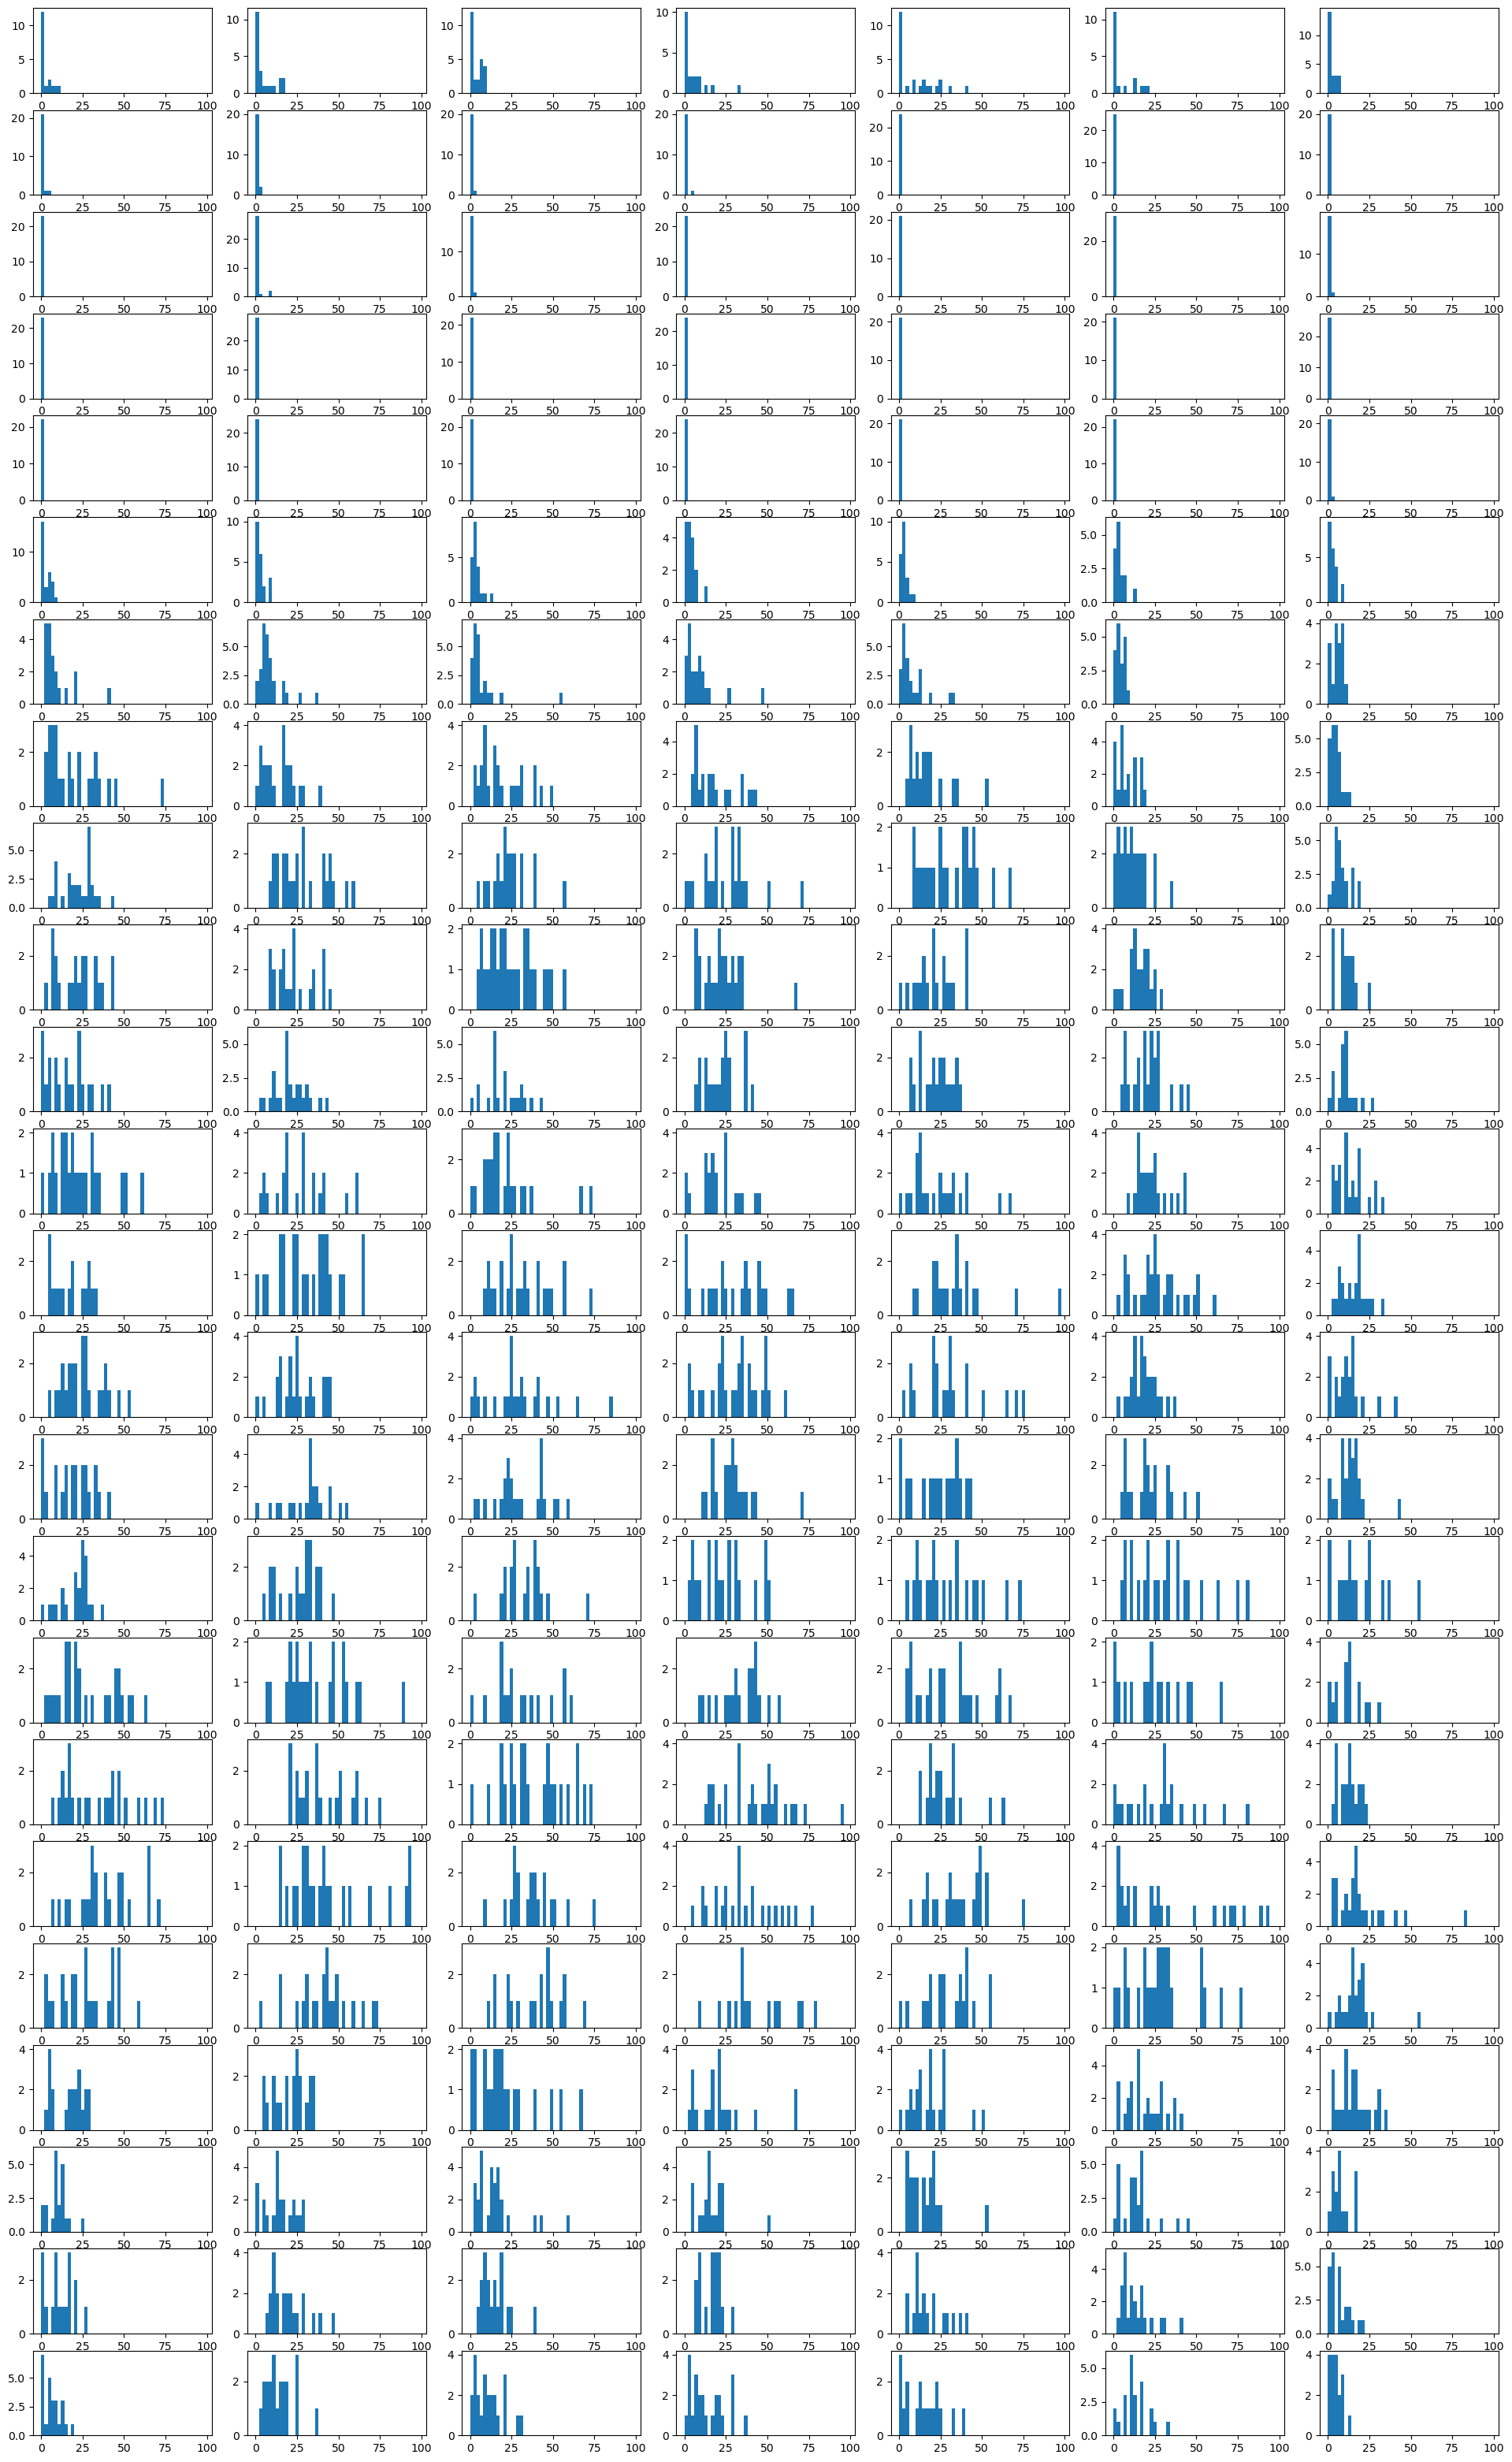

In [10]:
def plot_residual_hist(res_lower,bins =np.arange(0,100,2)):
    '''
    bins: 
    - [0,2,4,8,10,15,20,25,30,40,50,60,70,90,130,180]
    - [0,2,4,6,8,10,12,15,20,25,30,35,40,60,80]
    '''
    dic_residual_by_stations = {label: res_lower[torch.nonzero(T_cal == label,as_tuple = True)[0]][:,0,0] for label in T_cal.unique()}

    fig, axs = plt.subplots(24, 7,figsize=(24,40))
    for label in dic_residual_by_stations.keys():
        df = pd.DataFrame({label: dic_residual_by_stations[label]})
        label_i = int(label.item())
        i,j = label_i%24,label_i//24
        axs[i, j].hist(df[label],bins=bins)
    
plot_residual_hist(res_lower)

## Regardons la repartition des Upper-Residual, sur la station Ampère (postion 0), mais à travers tout les labels: 

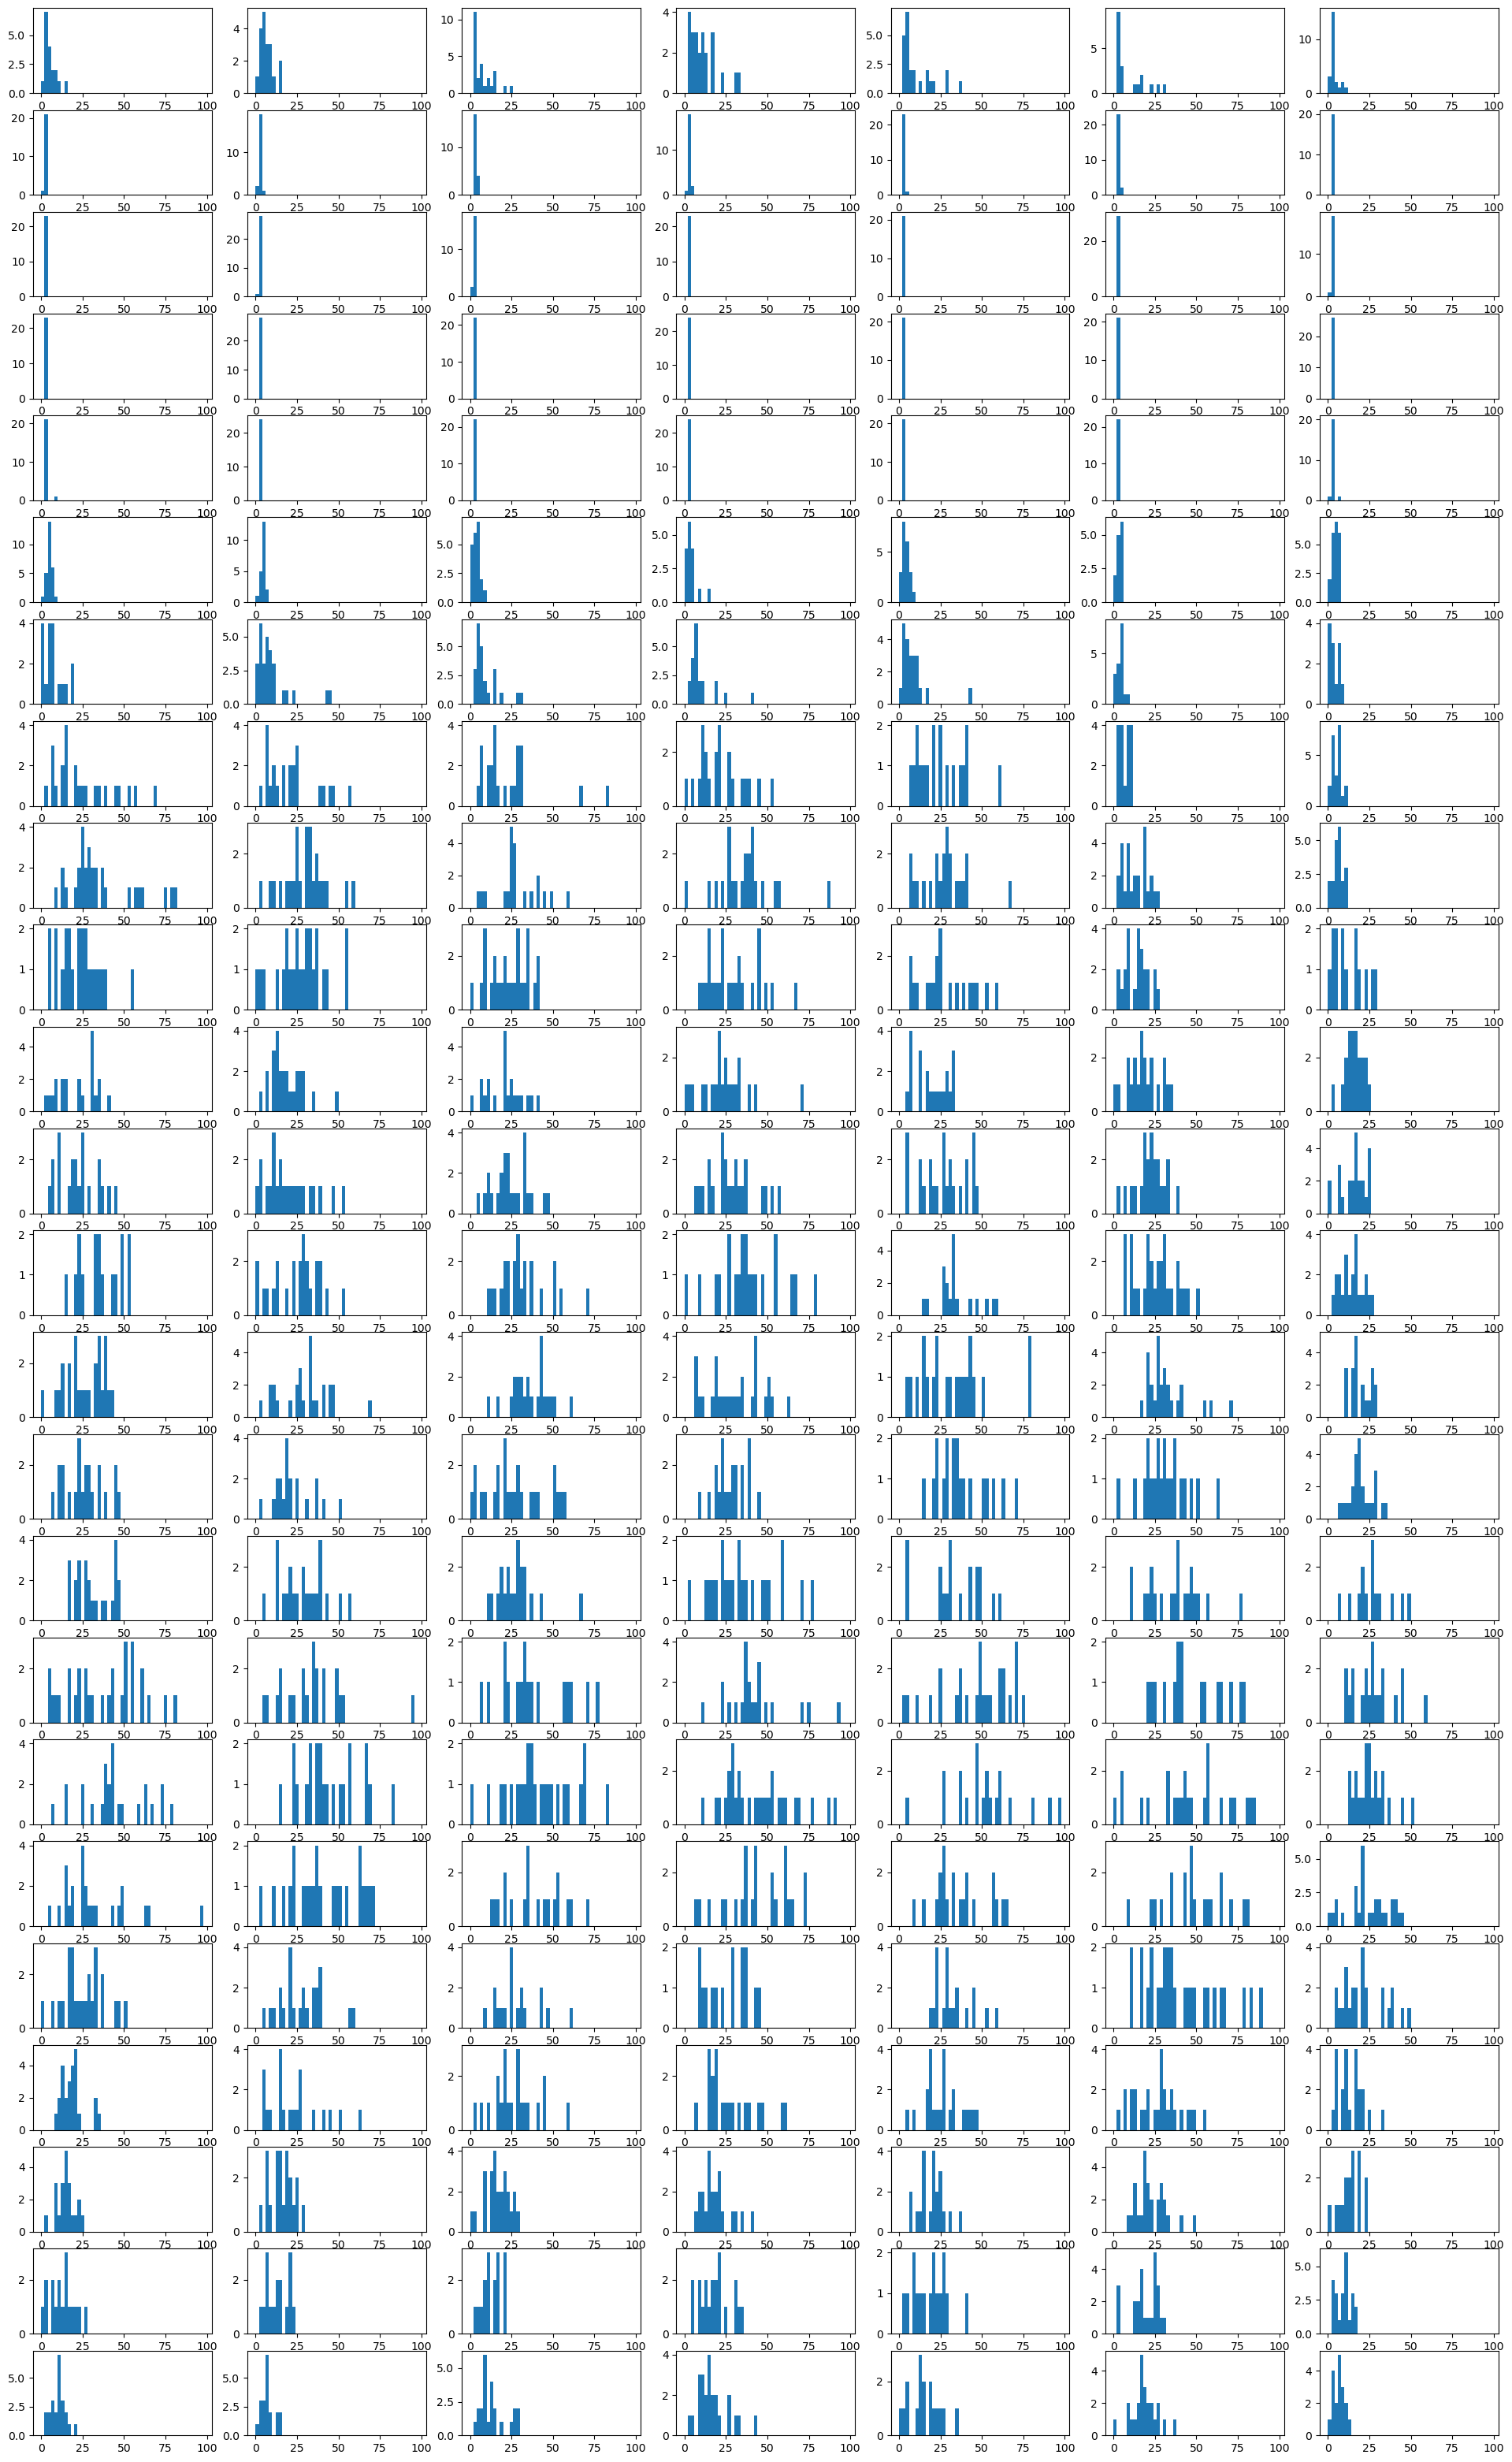

In [11]:
plot_residual_hist(res_upper)

## Regardons sur un unique Label (label 8 correspondant à Lundi 08:00):

array([[<Axes: title={'center': 'Ampère Victor Hugo'}>,
        <Axes: title={'center': 'Bellecour'}>,
        <Axes: title={'center': 'Brotteaux'}>,
        <Axes: title={'center': 'Charpennes'}>],
       [<Axes: title={'center': 'Cordeliers'}>,
        <Axes: title={'center': 'Croix Paquet'}>,
        <Axes: title={'center': 'Croix-Rousse'}>,
        <Axes: title={'center': 'Cuire'}>],
       [<Axes: title={'center': 'Cusset'}>,
        <Axes: title={'center': 'Debourg'}>,
        <Axes: title={'center': 'Flachet'}>,
        <Axes: title={'center': 'Foch'}>],
       [<Axes: title={'center': "Gare d'Oullins"}>,
        <Axes: title={'center': 'Gare de Vaise'}>,
        <Axes: title={'center': 'Gare de Vénissieux'}>,
        <Axes: title={'center': 'Garibaldi'}>],
       [<Axes: title={'center': 'Gorge de Loup'}>,
        <Axes: title={'center': 'Grange Blanche'}>,
        <Axes: title={'center': 'Gratte Ciel'}>,
        <Axes: title={'center': 'Guillotière'}>]], dtype=object)

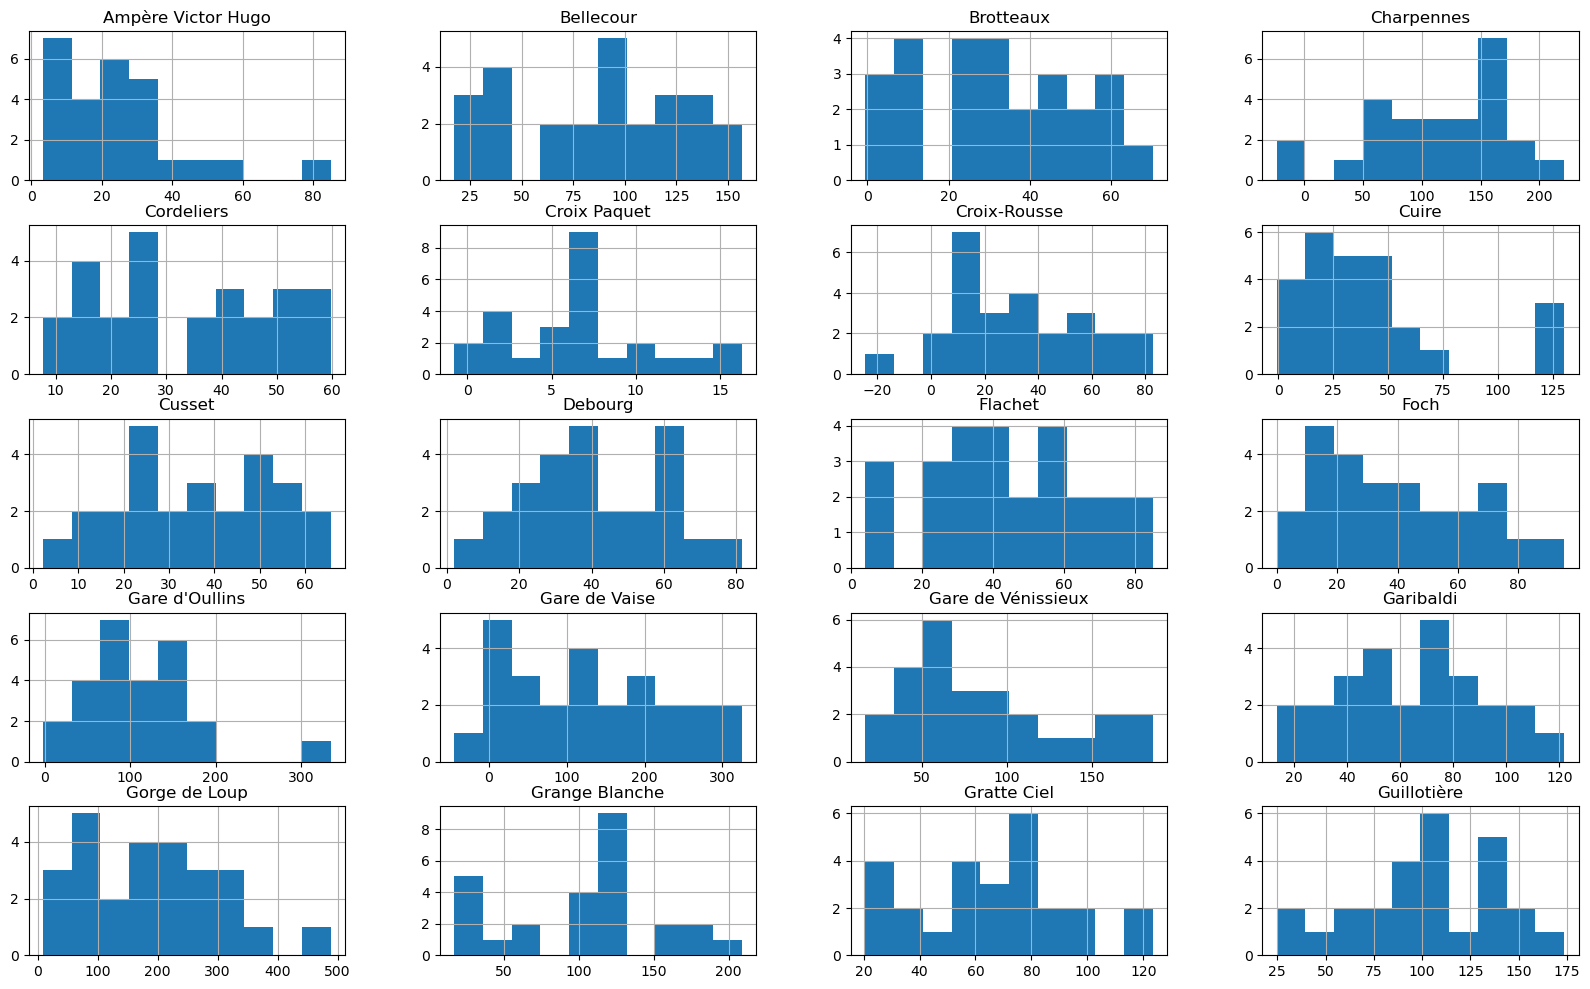

In [86]:
label = T_cal.unique()[8]
# Number of representation of label 'label' within Calibration DataSet
indices = torch.nonzero(T_cal == label,as_tuple = True)[0]

df_residual_by_stations = pd.DataFrame({c: res_lower[indices][:,k,0] for k,c in enumerate(trainer.dataset.spatial_unit)})
df_residual_by_stations.iloc[:,:20].hist(figsize=(20,12))

In [54]:
dic_label2Q = {}

#for label in T_cal.unique():
indices = torch.nonzero(T_cal == label,as_tuple = True)[0]
quantile_order = torch.Tensor([np.ceil((1 - trainer.args.alpha)*(indices.size(0)+1))/indices.size(0)]).to(trainer.args.device)  # Quantile for each class, so the quantile order is different as each class has a different length

In [ ]:
if False:
    # Get Confority scores: 
    if conformity_scores_type == 'max_residual':
        self.conformity_scores = torch.max(lower_q-Y_cal,Y_cal-upper_q).to(self.args.device) # Element-wise maximum        #'max(lower_q-y_b,y_b-upper_q)' is the quantile regression error function
    if conformity_scores_type == 'max_residual_plus_middle':
        str_info = str_info+ "\n|!| Conformity scores computation is not based on 'max(ql-y, y-qu)'"
        self.conformity_scores = torch.max(lower_q-Y_cal,Y_cal-upper_q) + ((lower_q>Y_cal)(upper_q<Y_cal))*(upper_q - lower_q)/2  # Element-wise maximum        #'max(lower_q-y_b,y_b-upper_q)' is the quantile regression error function
    # ...

    # Get Quantile:
    # If classic Calibration:
    if quantile_method == 'classic':  
        quantile_order = torch.Tensor([np.ceil((1 - alpha)*(X_cal.size(0)+1))/X_cal.size(0)]).to(self.args.device)
        #Q = torch.quantile(self.conformity_scores, quantile_order, dim = 0).to(self.device) #interpolation = 'higher'
        Q = get_higher_quantile(self.conformity_scores,quantile_order,device = self.args.device)
        output = Q

    # If Calibration by group of T_labels: 
    if quantile_method == 'compute_quantile_by_class':  # Calcul Higher Quantil for each calendar class. Several label can belongs to the same calendar class. The Quantile is computed through all residual of label of the same class
        calendar_class = torch.cat([t_cal for [_,_,_,t_cal] in data])
        dic_label2Q = {}
    # ...


        # Compute quantile for each calendar class : 
        nb_label_with_quantile_1 = 0
        for label in calendar_class.unique():
            indices = torch.nonzero(calendar_class == label,as_tuple = True)[0]
            quantile_order = torch.Tensor([np.ceil((1 - alpha)*(indices.size(0)+1))/indices.size(0)]).to(self.args.device)  # Quantile for each class, so the quantile order is different as each class has a different length
            quantile_order = min(torch.Tensor([1]).to(self.args.device),quantile_order)
            if quantile_order == 1: 
                nb_label_with_quantile_1 +=1
                #print(f"label {label} has only {indices.size(0)} elements in his class. We then use quantile order = 1")
            conformity_scores_i = self.conformity_scores[indices]
            scores_counts = conformity_scores_i.size(0)
            Q_i = get_higher_quantile(conformity_scores_i,quantile_order,device = self.args.device)
            #Q_i = torch.quantile(conformity_scores_i, quantile_order, dim = 0)#interpolation = 'higher'
            dic_label2Q[label.item()]= {'Q': Q_i,'count':scores_counts}

        str_info = str_info+ f"\nProportion of label with quantile order set to 1: {'{:.1%}'.format(nb_label_with_quantile_1/len(calendar_class.unique()))}"
        output = dic_label2Q
        

In [ ]:
# ==== Update Some Parameters:
config = model_perf['model'][best_trial]['args']
config['abs_path'] = f"{os.path.abspath(os.getcwd())}/"
config['device'] = 'cuda:0' if torch.cuda.is_available() else 'cpu'
config['K_fold'] = 6
args = convert_into_parameters(config)
# ==== ....

# ==== Load un-trained model: 
Datasets,DataLoader_list,dic_class2rpz,nb_words_embedding,time_slots_labels,dic_rpz2class = load_init_trainer(FOLDER_PATH,FILE_NAME,args)
(loss_function,Model_list,Optimizer_list,Scheduler_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding,dic_class2rpz,n_vertex = len(Datasets[0].spatial_unit))
multimodeltrainer = MultiModelTrainer(Datasets,Model_list,DataLoader_list,args,Optimizer_list,loss_function,Scheduler_list,args_embedding=args_embedding,dic_class2rpz=dic_class2rpz,show_figure=False)
# ==== ....

# ==== Load Trained Weight:
saved_checkpoint =  torch.load(best_model) if torch.cuda.is_available() else torch.load(best_model,map_location='cpu')
trainer = multimodeltrainer.Trainers[1]   # Fold1, très important car Fold0 a été pris pour le HP-Tuning. 
trainer.model.load_state_dict(saved_checkpoint['state_dict'])
# ===== ....

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0


/Users/romainrochas/opt/anaconda3/envs/ray/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00570927]
not reaching the requested tolerance 5.960464477539062e-07.
Use iteration 20 instead with accuracy 
0.004656454425472939.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/Users/romainrochas/opt/anaconda3/envs/ray/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00465645]
not reaching the requested tolerance 5.960464477539062e-07.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/Users/romainrochas/opt/anaconda3/envs/ray/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00225358]
not reaching the requested tolerance 5.960464477539062e-07.
Use iteration 21 instead with accuracy 
0.0022535813386284948.

  _, eigvec = lobpcg(XH_X, X, tol=t

<All keys matched successfully>

# Calibration sur un modèle qui est moins performant : 

In [6]:
# Ici on regarde la calibration classique, celle qui ne fait aucune distinction selon les 'classes' considérée.
Q = trainer.conformal_calibration(trainer.alpha,trainer.dataset,conformity_scores_type = 'max_residual',quantile_method = 'classic',print_info = True)
pi,pi_cqr = generate_bokeh(trainer,trainer.dataloader,trainer.dataset,Q,args,dic_class2rpz,station=0,show_figure = True,save_plot = False)

# Qui est totalement équivalent à :
#calibration_calendar_class = 0
#Q = trainer.conformal_calibration(trainer.alpha,trainer.dataset,conformity_scores_type = 'max_residual',quantile_method = 'compute_quantile_by_class',print_info = True,calibration_calendar_class = calibration_calendar_class)
#pi,pi_cqr = generate_bokeh(trainer,trainer.dataloader,trainer.dataset,Q,args,dic_class2rpz,station=0,show_figure = True,save_plot = False,calibration_calendar_class = calibration_calendar_class)

Loading BokehJS ...

### Calibration CQR autres : 

In [7]:
calibration_calendar_class = 3
for calibration_calendar_class in [1,2,3]:
    Q = trainer.conformal_calibration(trainer.alpha,trainer.dataset,conformity_scores_type = 'max_residual',quantile_method = 'compute_quantile_by_class',print_info = True,calibration_calendar_class = calibration_calendar_class)
    pi,pi_cqr = generate_bokeh(trainer,trainer.dataloader,trainer.dataset,Q,args,dic_class2rpz,station=0,show_figure = True,save_plot = False,calibration_calendar_class = calibration_calendar_class)


Proportion of label with quantile order set to 1: 0.0%


Loading BokehJS ...


Proportion of label with quantile order set to 1: 96.3%


Loading BokehJS ...


Proportion of label with quantile order set to 1: 0.0%


Loading BokehJS ...

## Pour l'instant, rien de très convainquant.

# Quantraffic

In [8]:
# ==== QuanTraffic Calibration : 
# Load Y_pred_calibration1 and Y_pred_calibration2
split_prop = 0.5
nb_quantiles = 99
n_lambda = 50 #41 
lambda_list = np.arange(0,n_lambda)/n_lambda

Q_calibration_table = get_QuanTraffic_calibration_table(trainer,split_prop,nb_quantiles,lambda_list)

In [9]:
pi,pi_cqr = generate_bokeh(trainer,trainer.dataloader,trainer.dataset,Q_calibration_table.unsqueeze(0),args,dic_class2rpz,station=0,show_figure = True,save_plot = False)

Loading BokehJS ...

# `Ici aussi les calibrations ne semble pas très bonne. Au moins cette fois-ci les intervalles sont plus restreint. Peut être que c'est utile qu'a partir du moment où le model n'est pas très bien entrainé. Mais cela ne reste pas très convaincant...`